In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

from google.colab import drive
drive.mount('/content/drive')

RANDOM_STATE = 42

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Reading and Merging the data

In [77]:
file_path = '/content/drive/MyDrive/Colab Notebooks/singlife-assessment/DataScientist_CaseStudy_Dataset.xlsx'
soc_dem = pd.read_excel(file_path, sheet_name='Soc_Dem')
pdt_balance = pd.read_excel(file_path, sheet_name='Products_ActBalance')
inflow_outflow = pd.read_excel(file_path, sheet_name='Inflow_Outflow')
sales_revenues = pd.read_excel(file_path, sheet_name='Sales_Revenues')

#Merge dataframes into one
df = soc_dem.merge(pdt_balance, on="Client", how="outer") \
               .merge(inflow_outflow, on="Client", how="outer") \
               .merge(sales_revenues, on="Client", how="outer")

# Processing the data

In [78]:
#Investigate samples with null target variable
df.loc[df.Sale_MF.isna()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 646 entries, 2 to 1613
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Client                        646 non-null    int64  
 1   Sex                           645 non-null    object 
 2   Age                           646 non-null    int64  
 3   Tenure                        646 non-null    int64  
 4   Count_CA                      646 non-null    int64  
 5   Count_SA                      161 non-null    float64
 6   Count_MF                      122 non-null    float64
 7   Count_OVD                     168 non-null    float64
 8   Count_CC                      60 non-null     float64
 9   Count_CL                      56 non-null     float64
 10  ActBal_CA                     646 non-null    float64
 11  ActBal_SA                     161 non-null    float64
 12  ActBal_MF                     122 non-null    float64
 13  ActBal_OV

It appears that 646 samples have null for the 6 target variables. This means we cannot use them for training our model or evaluating model performance.

Nevertheless, they are still part of our client list and should still be included in the eventual high propensity client lists.

We will follow this process:
- Use 969 samples with labels to define train and test data
- Train a model
- Use the model for inference on all 1615 samples, evaluating the propensity to buy and coming up with the high propensity client lists



## Label encoding and treating missing values

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Client                        1615 non-null   int64  
 1   Sex                           1612 non-null   object 
 2   Age                           1615 non-null   int64  
 3   Tenure                        1615 non-null   int64  
 4   Count_CA                      1615 non-null   int64  
 5   Count_SA                      426 non-null    float64
 6   Count_MF                      306 non-null    float64
 7   Count_OVD                     419 non-null    float64
 8   Count_CC                      170 non-null    float64
 9   Count_CL                      135 non-null    float64
 10  ActBal_CA                     1615 non-null   float64
 11  ActBal_SA                     426 non-null    float64
 12  ActBal_MF                     306 non-null    float64
 13  Act

Quite a few of the features have null or missing values. It'll be good to inpute them since some models and upsampling using SMOTE do not work when missing values are present.

- For Sex, there are 3 samples with missing values. It isn't fair to impute them with the most frequent value, so we will replace the missing values with "unknown". In addition, we will use label encoding to convert the values to integers.

- For the other columns, they refer to number of financial products, account balance, turnover and number of transactions, all of which makes sense if we inpute missing values as 0.

In [79]:
df['Sex'] = df['Sex'].fillna('unknown')
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(label_mapping)

df.iloc[:, 5:30] = df.iloc[:, 5:30].fillna(0)

{'F': 0, 'M': 1, 'unknown': 2}


## Creating new features

Based on the existing features, we can engineer new features to improve predictability. In particular, we introduce the following features:

- Total Credit Product Count: total number of credit products such as live credit cards, overdrafts and consumer loans
  > Higher values may indicate a stronger engagement with credit products, making them more likely to be interested in similar offerings

- Credit Product Balance: total amount of liability/debt for credit products
  > Clients with higher debt might be less likely to take on more loans or credit cards

- Credit vs Debit Turnover: ratio of credit turnover to debit turnover
  > A higher value may indicate that client is more inclined to use credit over debit, potentially making them a better candidate for credit products

- Credit Debit Transaction Ratio: ratio of number of credit transactions to debit transactions
  > This gives us an idea of client's preference for credit vs debit transactions. Clients with higher ratios may be more interested in credit products

- Credit Transaction Frequency: average number of credit transactions per month
  > This can help us identify highly active users for credit products

- Debit Transaction Frequency: average number of debit transactions per month
  > Higher frequency of debit transactions may indicate a higher volume of spending and a potential need for more financial products

It's worthy to note that these features are related to credit usage and therefore more useful in predicting sale of credit products such as credit card and consumer loan, instead of an investment product such as mutual fund.

In addition, given that some of these features involve division, we need to ensure we do not encounter division by zero error. We can mitigate this by:
- Adding a small value to the denominator
- For Tenure, value 0 likely means clients still have not reached 1 month tenure with the bank yet. It should be fair to replace these values with 1.

In [80]:
df['Total_Credit_Product_Count'] = df['Count_CC'] + df['Count_OVD'] + df['Count_CL']
df['Credit_Product_Balance'] = df['ActBal_CC'] + df['ActBal_OVD'] + df['ActBal_CL']

EPSILON = 1e-6  # Small number to prevent division by zero
df['Credit_vs_Debit_Turnover'] = df['VolumeCred'] / (df['VolumeDeb'] + EPSILON)
df['Credit_Debit_Transaction_Ratio'] = df['TransactionsCred'] / (df['TransactionsDeb'] + EPSILON)
df['Adjusted_Tenure'] = df['Tenure'].replace(0, 1)            # Replace 0 with 1 month
df['Credit_Transaction_Frequency'] = df['TransactionsCred'] / df['Adjusted_Tenure']
df['Debit_Transaction_Frequency'] = df['TransactionsDeb'] / df['Adjusted_Tenure']

# Preparing training and test data

First, we drop and set aside the samples that do not have any labels. We will only perform inference on these samples later after we train a model.



In [81]:
df_combined = df.copy()
df = df.dropna(subset=['Sale_MF'])

Next, we investigate the proportion for each target variable. As we see below, there is some class imbalance. Given the limited number of samples, it's not wise to downsample the majority class.

Other plausible options we have are to upsample the minority class using SMOTE or put a higher weightage to the minority class during training.

In [82]:
for col in ['Sale_CC', 'Sale_CL', 'Sale_MF']:
  print(df[col].value_counts().reset_index())

   Sale_CC  count
0      0.0    727
1      1.0    242
   Sale_CL  count
0      0.0    679
1      1.0    290
   Sale_MF  count
0      0.0    776
1      1.0    193


In [83]:
X = df.drop(df.columns[30:36], axis=1)
X_mf = X.drop(columns=['Client', 'Total_Credit_Product_Count', 'Credit_Product_Balance', 'Credit_vs_Debit_Turnover', 'Credit_Debit_Transaction_Ratio', 'Adjusted_Tenure', 'Credit_Transaction_Frequency']) #, 'Debit_Transaction_Frequency'])
X_cc_cl = X.drop(columns=['Client', 'Tenure'])
y_mf = df.iloc[:, 30]
y_cc = df.iloc[:, 31]
y_cl = df.iloc[:, 32]

To prepare the train and test data, we do a stratified split to maintain the proportion of classes. We opt for a 70/30 split so that there are sufficient test samples to evaluate performance.

In [84]:
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(X_cc_cl, y_cc, test_size=0.3, stratify=y_cc, random_state=RANDOM_STATE)
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_cc_cl, y_cl, test_size=0.3, stratify=y_cl, random_state=RANDOM_STATE)
X_train_mf, X_test_mf, y_train_mf, y_test_mf = train_test_split(X_mf, y_mf, test_size=0.3, stratify=y_mf, random_state=RANDOM_STATE)

In [85]:
#Upsampling using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=RANDOM_STATE)
X_resampled_cc, y_resampled_cc = smote.fit_resample(X_train_cc, y_train_cc)
X_resampled_cl, y_resampled_cl = smote.fit_resample(X_train_cl, y_train_cl)
X_resampled_mf, y_resampled_mf = smote.fit_resample(X_train_mf, y_train_mf)

# Training model and evaluating performance

#Sale of consumer loan

In [18]:
# Train a Random Forest model for Credit Card purchase
rf_model_cl = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
lgb_model_cl = lgb.LGBMClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    boosting_type='gbdt',
    learning_rate=0.05,
    max_depth=-1,        # No depth limit
    num_leaves=31        # Default number of leaves
)
xgb_model_cl = xgb.XGBClassifier(
    n_estimators=100,
    eval_metric='logloss',
    random_state=RANDOM_STATE,
    use_label_encoder=False
)

for model in [rf_model_cl, lgb_model_cl, xgb_model_cl]:
  model.fit(X_resampled_cl, y_resampled_cl)

  # Print model hyperparameters
  print(f"Hyperparameters for {model.__class__.__name__}:")
  print(model.get_params())
  print('-' * 50)

  # Predictions
  y_pred_cl = model.predict(X_test_cl)
  print(classification_report(y_test_cl, y_pred_cl))
  print(f'F1 Score: {f1_score(y_test_cl, y_pred_cl)}')

Hyperparameters for RandomForestClassifier:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.74      0.79      0.76       204
         1.0       0.41      0.34      0.38        87

    accuracy                           0.66       291
   macro avg       0.57      0.57      0.57       291
weighted avg       0.64      0.66      0.65       291

F1 Score: 0.375
[LightGBM] [Info] Number of positive: 475, number of negative: 475
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:54:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Hyperparameters for XGBClassifier:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}
-----------------------------------

Looks like the best performing model is XGBoost. We can further boost performance by using hyperparameter tuning.

In [19]:
xgb_model_cl_opt = xgb.XGBClassifier(use_label_encoder=False)

param_dist_cl = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

random_search_cl = RandomizedSearchCV(estimator=xgb_model_cl_opt, param_distributions=param_dist_cl,
                                   n_iter=50, cv=5, scoring='f1', verbose=2, n_jobs=-1, random_state=RANDOM_STATE)
random_search_cl.fit(X_resampled_cl, y_resampled_cl)
print("Best Parameters:", random_search_cl.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:55:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [20]:
best_model_cl = random_search_cl.best_estimator_
y_pred_cl = best_model_cl.predict(X_test_cl)
print(classification_report(y_test_cl, y_pred_cl))
print(f'F1 Score: {f1_score(y_test_cl, y_pred_cl)}')

              precision    recall  f1-score   support

         0.0       0.75      0.80      0.78       204
         1.0       0.45      0.38      0.41        87

    accuracy                           0.68       291
   macro avg       0.60      0.59      0.59       291
weighted avg       0.66      0.68      0.67       291

F1 Score: 0.4125


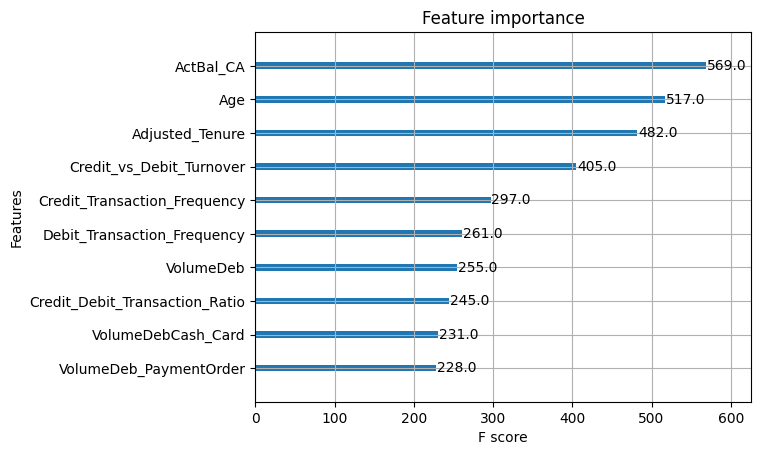

In [21]:
xgb.plot_importance(best_model_cl, importance_type='weight', max_num_features=10)
plt.show()

In [22]:
#Derive probabilities from combined df (including those with no labels)
columns_to_drop = ['Sale_MF', 'Sale_CC', 'Sale_CL','Revenue_MF', 'Revenue_CC', 'Revenue_CL', 'Tenure', 'Client']
y_probs_cl = best_model_cl.predict_proba(df_combined.drop(columns = columns_to_drop))[:, 1]

In [23]:
df_combined['Propensity_CL'] = y_probs_cl

In [24]:
df_combined.loc[df_combined['Propensity_CL'] >= 0.5].sort_values(by = 'Propensity_CL', ascending = False)[:50]

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,Revenue_CC,Revenue_CL,Total_Credit_Product_Count,Credit_Product_Balance,Credit_vs_Debit_Turnover,Credit_Debit_Transaction_Ratio,Adjusted_Tenure,Credit_Transaction_Frequency,Debit_Transaction_Frequency,Propensity_CL
315,316,0,1,211,1,0.0,0.0,0.0,0.0,0.0,...,0.000000,15.015357,0.0,0.000000,0.996132,0.285714,211,0.028436,0.099526,0.990844
1230,1231,0,6,232,1,0.0,0.0,0.0,0.0,0.0,...,0.000000,24.434643,0.0,0.000000,0.000007,0.222222,232,0.008621,0.038793,0.979840
774,775,1,40,151,2,2.0,1.0,1.0,0.0,1.0,...,0.000000,19.035714,2.0,277.086429,1.013415,0.684211,151,0.258278,0.377483,0.977616
297,298,1,48,221,1,2.0,3.0,1.0,1.0,0.0,...,0.000000,22.966429,2.0,0.000000,0.888160,0.583333,221,0.063348,0.108597,0.977003
1154,1155,0,69,219,1,0.0,0.0,0.0,0.0,0.0,...,0.214286,11.976429,0.0,0.000000,0.993381,0.666666,219,0.009132,0.013699,0.976448
101,102,1,20,172,1,0.0,0.0,1.0,0.0,0.0,...,0.000000,6.952500,1.0,114.140000,0.979933,0.441860,172,0.220930,0.500000,0.971992
1158,1159,0,33,128,1,1.0,0.0,0.0,0.0,0.0,...,0.893929,4.830714,0.0,0.000000,0.503739,0.280000,128,0.054688,0.195312,0.971395
349,350,0,4,218,1,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,1.0,0.000000,1.055060,0.777778,218,0.128440,0.165138,0.970294
1498,1499,0,5,267,1,0.0,0.0,1.0,0.0,1.0,...,0.000000,7.107143,2.0,12865.612500,0.794068,0.161290,267,0.018727,0.116105,0.969583
494,495,0,19,150,1,0.0,5.0,0.0,1.0,0.0,...,0.000000,4.488214,1.0,641.575357,0.431571,0.210526,150,0.080000,0.380000,0.966931


# Sale of credit card

In [25]:
# Train a Random Forest model for Credit Card purchase
rf_model_cc = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
lgb_model_cc = lgb.LGBMClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    boosting_type='gbdt',
    learning_rate=0.05,
    max_depth=-1,        # No depth limit
    num_leaves=31        # Default number of leaves
)
xgb_model_cc = xgb.XGBClassifier(
    n_estimators=100,
    eval_metric='logloss',
    random_state=RANDOM_STATE,
    use_label_encoder=False
)

for model in [rf_model_cc, lgb_model_cc, xgb_model_cc]:
  model.fit(X_resampled_cc, y_resampled_cc)

  # Print model hyperparameters
  print(f"Hyperparameters for {model.__class__.__name__}:")
  print(model.get_params())
  print('-' * 50)


  # Predictions
  y_pred_cc = model.predict(X_test_cc)
  print(classification_report(y_test_cc, y_pred_cc))
  print(f'F1 Score: {f1_score(y_test_cc, y_pred_cc)}')

Hyperparameters for RandomForestClassifier:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82       218
         1.0       0.39      0.27      0.32        73

    accuracy                           0.71       291
   macro avg       0.59      0.57      0.57       291
weighted avg       0.68      0.71      0.69       291

F1 Score: 0.3225806451612903
[LightGBM] [Info] Number of positive: 509, number of negative: 509
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhe

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:56:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Hyperparameters for XGBClassifier:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}
-----------------------------------

In [26]:
lgb_model_cc_opt = lgb.LGBMClassifier(random_state=RANDOM_STATE, boosting_type='gbdt')

param_dist_cc = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, -1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [20, 30, 50],
    'num_leaves': [31, 63, 127]
}

random_search_cc = RandomizedSearchCV(estimator=lgb_model_cc_opt, param_distributions=param_dist_cc,
                                   n_iter=50, cv=5, scoring='f1', verbose=2, n_jobs=-1, random_state=RANDOM_STATE)
random_search_cc.fit(X_resampled_cc, y_resampled_cc)
print("Best Parameters:", random_search_cc.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 509, number of negative: 509
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5471
[LightGBM] [Info] Number of data points in the train set: 1018, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [27]:
best_model_cc = random_search_cc.best_estimator_
importances_cc = best_model_cc.feature_importances_
feature_names_cc = best_model_cc.feature_name_
feature_importance_dict_cc = dict(zip(feature_names_cc, importances_cc))

sorted_features_cc = sorted(feature_importance_dict_cc.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features_cc:
    print(f"{feature}: {importance}")

ActBal_CA: 254
Adjusted_Tenure: 251
Age: 241
Credit_vs_Debit_Turnover: 210
VolumeCred: 197
Credit_Debit_Transaction_Ratio: 195
Credit_Transaction_Frequency: 188
VolumeDeb_PaymentOrder: 167
Debit_Transaction_Frequency: 165
VolumeCred_CA: 160
VolumeDebCash_Card: 160
VolumeDeb: 153
ActBal_SA: 148
TransactionsDeb_PaymentOrder: 146
TransactionsCred_CA: 123
TransactionsDebCashless_Card: 108
TransactionsCred: 107
TransactionsDebCash_Card: 105
VolumeDebCashless_Card: 101
VolumeDeb_CA: 89
TransactionsDeb: 89
Count_OVD: 87
TransactionsDeb_CA: 83
Count_MF: 68
Count_SA: 63
Credit_Product_Balance: 48
Sex: 44
ActBal_CC: 41
Total_Credit_Product_Count: 29
ActBal_MF: 26
Count_CC: 22
ActBal_OVD: 21
Count_CA: 14
Count_CL: 13
ActBal_CL: 10


In [28]:
y_pred_cc = best_model_cc.predict(X_test_cc)
print(classification_report(y_test_cc, y_pred_cc))
print(f'F1 Score: {f1_score(y_test_cc, y_pred_cc)}')

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.82       218
         1.0       0.40      0.25      0.31        73

    accuracy                           0.72       291
   macro avg       0.59      0.56      0.56       291
weighted avg       0.68      0.72      0.69       291

F1 Score: 0.3050847457627119


In [29]:
y_probs_cc = best_model_cc.predict_proba(df_combined[feature_names_cc])[:, 1]
df_combined['Propensity_CC'] = y_probs_cc

In [30]:
df_combined

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,Revenue_CL,Total_Credit_Product_Count,Credit_Product_Balance,Credit_vs_Debit_Turnover,Credit_Debit_Transaction_Ratio,Adjusted_Tenure,Credit_Transaction_Frequency,Debit_Transaction_Frequency,Propensity_CL,Propensity_CC
0,1,0,51,7,1,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.000000,0.887696,0.500000,7,3.571429,7.142857,0.051009,0.017179
1,2,1,43,152,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,1.832430,0.666667,152,0.026316,0.039474,0.812330,0.025381
2,3,1,17,140,1,0.0,1.0,0.0,0.0,0.0,...,NaN,0.0,0.000000,12.987068,1.333333,140,0.028571,0.021429,0.170085,0.009319
3,4,1,24,153,1,1.0,0.0,0.0,1.0,0.0,...,NaN,1.0,1110.381786,0.518012,0.219512,153,0.058824,0.267974,0.769437,0.017543
4,5,0,58,200,1,1.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.000000,0.745131,0.522727,200,0.115000,0.220000,0.754271,0.035314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,1611,0,41,181,1,0.0,0.0,1.0,0.0,0.0,...,NaN,1.0,0.000000,0.932318,0.272727,181,0.016575,0.060773,0.638188,0.029880
1611,1612,1,63,114,1,0.0,0.0,1.0,0.0,1.0,...,0.0,2.0,6250.000000,1.371915,0.666667,114,0.070175,0.105263,0.066663,0.044163
1612,1613,1,46,45,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,1.067661,0.160000,45,0.088889,0.555556,0.149987,0.007493
1613,1614,1,48,65,1,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.000000,1.119886,0.200000,65,0.046154,0.230769,0.608158,0.475194


# Sale of mutual fund

In [86]:
# Train a Random Forest model for Credit Card purchase
rf_model_mf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
lgb_model_mf = lgb.LGBMClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    boosting_type='gbdt',
    learning_rate=0.05,
    max_depth=-1,        # No depth limit
    num_leaves=31        # Default number of leaves
)
xgb_model_mf = xgb.XGBClassifier(
    n_estimators=100,
    eval_metric='logloss',
    random_state=RANDOM_STATE,
    use_label_encoder=False
)

for model in [rf_model_mf, lgb_model_mf, xgb_model_mf]:
  model.fit(X_resampled_mf, y_resampled_mf)

  # Print model hyperparameters
  print(f"Hyperparameters for {model.__class__.__name__}:")
  print(model.get_params())
  print('-' * 50)

  # Predictions
  y_pred_mf = model.predict(X_test_mf)
  print(classification_report(y_test_mf, y_pred_mf))
  print(f'F1 Score: {f1_score(y_test_mf, y_pred_mf)}')

Hyperparameters for RandomForestClassifier:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85       233
         1.0       0.28      0.17      0.21        58

    accuracy                           0.75       291
   macro avg       0.54      0.53      0.53       291
weighted avg       0.71      0.75      0.72       291

F1 Score: 0.2127659574468085
[LightGBM] [Info] Number of positive: 543, number of negative: 543
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhe

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:38:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Hyperparameters for XGBClassifier:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}
-----------------------------------

In [87]:
xgb_model_mf_opt = xgb.XGBClassifier(use_label_encoder=False)

param_dist_mf = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

random_search_mf = RandomizedSearchCV(estimator=xgb_model_mf_opt, param_distributions=param_dist_mf,
                                   n_iter=50, cv=5, scoring='f1', verbose=2, n_jobs=-1, random_state=RANDOM_STATE)
random_search_mf.fit(X_resampled_mf, y_resampled_mf)
print("Best Parameters:", random_search_mf.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:39:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [88]:
best_model_mf = random_search_mf.best_estimator_
y_pred_mf = best_model_mf.predict(X_test_mf)
print(classification_report(y_test_mf, y_pred_mf))
print(f'F1 Score: {f1_score(y_test_mf, y_pred_mf)}')

              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       233
         1.0       0.32      0.21      0.25        58

    accuracy                           0.76       291
   macro avg       0.57      0.55      0.55       291
weighted avg       0.72      0.76      0.73       291

F1 Score: 0.25263157894736843


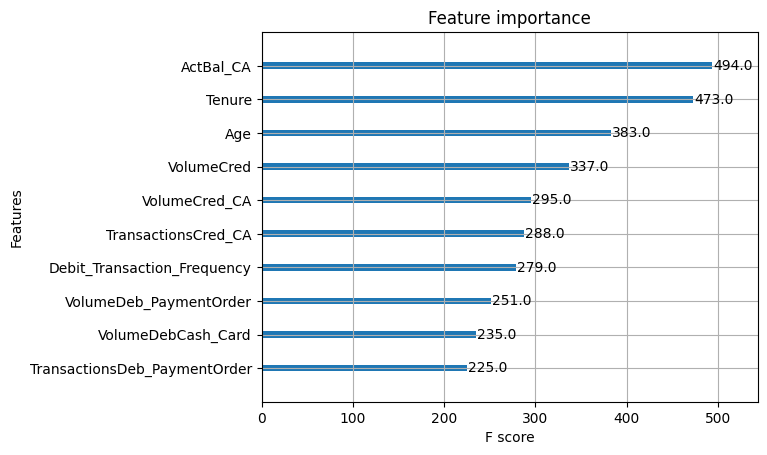

In [34]:
xgb.plot_importance(best_model_mf, importance_type='weight', max_num_features=10)
plt.show()

In [40]:
y_probs_mf = best_model_mf.predict_proba(df_combined[X_resampled_mf.columns])[:, 1]
df_combined['Propensity_MF'] = y_probs_mf

# Revenue calculation and generating client list

Now that we have the 3 propensity models, we can calculate the expected revenue for each person and generate the client list:
1. Calculate median revenue for each product
   > We use median instead of mean, since it is more robust to outliers
2. For each client, take propensity to purchase * median revenue to get expected revenue for each of the 3 products
3. Take the maximum expected revenue across the 3 products to decide which offer the client should be targeted with
4. Select the top 15% of clients in terms of expected revenue to be targeted

In [43]:
median_revenue_cl = df_combined.query('Revenue_CL!=0')['Revenue_CL'].median()
median_revenue_cc = df_combined.query('Revenue_CC!=0')['Revenue_CC'].median()
median_revenue_mf = df_combined.query('Revenue_MF!=0')['Revenue_MF'].median()
print(median_revenue_cl, median_revenue_cc, median_revenue_mf)

10.743035714285714 4.376964285714285 3.0798214285714285


In [45]:
df_combined['Expected_Revenue_CL'] = median_revenue_cl * df_combined['Propensity_CL']
df_combined['Expected_Revenue_CC'] = median_revenue_cc * df_combined['Propensity_CC']
df_combined['Expected_Revenue_MF'] = median_revenue_mf * df_combined['Propensity_MF']

In [46]:
df_combined['Max_Expected_Revenue'] = df_combined[['Expected_Revenue_CL', 'Expected_Revenue_CC', 'Expected_Revenue_MF']].max(axis=1)

def determine_best_offer(row):
    if row['Expected_Revenue_CL'] == row['Max_Expected_Revenue']:
        return 'CL'
    elif row['Expected_Revenue_CC'] == row['Max_Expected_Revenue']:
        return 'CC'
    elif row['Expected_Revenue_MF'] == row['Max_Expected_Revenue']:
        return 'MF'

df_combined['Best_Offer'] = df_combined.apply(lambda row: determine_best_offer(row), axis=1)

In [48]:
df_sorted = df_combined.sort_values(by='Max_Expected_Revenue', ascending=False)

# Calculate the cutoff for the top 15%
top_15_percent = int(0.15 * len(df_sorted))

# Select the top 15% of rows
df_top_15_percent = df_sorted.head(top_15_percent)
df_top_15_percent

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,Credit_Transaction_Frequency,Debit_Transaction_Frequency,Propensity_CL,Propensity_CC,Propensity_MF,Expected_Revenue_CL,Expected_Revenue_CC,Expected_Revenue_MF,Max_Expected_Revenue,Best_Offer
315,316,0,1,211,1,0.0,0.0,0.0,0.0,0.0,...,0.028436,0.099526,0.990844,0.007005,0.062591,10.644674,0.030662,0.192768,10.644674,CL
1230,1231,0,6,232,1,0.0,0.0,0.0,0.0,0.0,...,0.008621,0.038793,0.979840,0.035384,0.010899,10.526450,0.154873,0.033566,10.526450,CL
774,775,1,40,151,2,2.0,1.0,1.0,0.0,1.0,...,0.258278,0.377483,0.977616,0.551861,0.223621,10.502566,2.415474,0.688712,10.502566,CL
297,298,1,48,221,1,2.0,3.0,1.0,1.0,0.0,...,0.063348,0.108597,0.977003,0.016766,0.021906,10.495976,0.073383,0.067466,10.495976,CL
1154,1155,0,69,219,1,0.0,0.0,0.0,0.0,0.0,...,0.009132,0.013699,0.976448,0.991416,0.058706,10.490013,4.339394,0.180804,10.490013,CL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,168,0,26,168,1,1.0,0.0,1.0,0.0,0.0,...,0.017857,0.041667,0.799483,0.113622,0.060614,8.588877,0.497321,0.186681,8.588877,CL
454,455,0,32,15,1,2.0,0.0,0.0,1.0,0.0,...,1.600000,3.133333,0.798607,0.990487,0.096526,8.579462,4.335326,0.297283,8.579462,CL
1595,1596,1,49,78,1,1.0,0.0,0.0,0.0,0.0,...,0.038462,0.012821,0.796615,0.012492,0.093531,8.558062,0.054677,0.288060,8.558062,CL
1208,1209,1,50,19,1,0.0,0.0,0.0,0.0,0.0,...,0.105263,0.105263,0.795646,0.002302,0.028155,8.547653,0.010076,0.086712,8.547653,CL


In [54]:
df_top_15_percent.Best_Offer.value_counts().reset_index()

,Best_Offer,count
0,CL,242


In [55]:
df_top_15_percent.Max_Expected_Revenue.sum()

np.float64(2323.102210044861)

Total Expected Revenue from our strategy is 2323.10.

In [53]:
df_top_15_percent[['Client', 'Best_Offer']].to_csv('/content/drive/MyDrive/Colab Notebooks/singlife-assessment/TargetedClientList.csv', index=False)